# PP-L价差投机--策略性能分析报告

## 策略基本情况

### 策略逻辑：
    对价差信号，做择时投机
    
### 操作周期
    tick级别

### 进场信号：
    价差突变，产生择时信号

### 出场信号：
    1.固定止盈
    2.超时止损
    3.固定止损


## 需要完成的回测内容

    为了完成完整的分析报告，请完成下面的内容：
    1.快速模式和慢速模式的回测
    2.参数扫描回测
    3.不同品种的回测
    4.使用步骤2.获得的稳定参数，在样本时间外回测
    5.填写下面的策略基本情况，将会根据回测内容自动生成策略报告
    
## 生成的分析内容
    
    1.策略速度要求分析
    2.策略参数稳定性分析
    3.策略的品种稳定性
    4.策略的样本外回测
    5.实盘记录 
    

In [1]:
# 策略的基本参数（需要修改的地方）
#############################################################

# 策略占用的总资金
strategyCap  = 9000

# 策略回测使用的时间区间
startDate = '20160331'
endDate = '20160815'

# 快速回测的策略名
strategyNameF = 'tl for pp-l f'

# 慢速回测的策略名
strategyNameS = 'tl for pp-l s'

# 参数扫描的策略名
strategyName = 'tl for pp-l' 

# 其他品种上的回测
strategyNameL = ['tl for a-m','tl for y-OI']
strategyCapL  = [6000,9000]

# 样本外回测的策略名
strategyNameOS = 'tl for pp-l 0'

# 样本外回测使用的时间区间
startDateOS = '20160801'
endDateOS = '20161130'

#############################################################
# 导入需要的库
from vtFunction import *
from ctaBase import *
from sklearn.cluster import Birch
from sklearn.cluster import KMeans
import os
import csv
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 打印盈亏的函数
#############################################################
def plotCapCv(strategyNames,strategyBases,startDate,endDate,title = u''):
    plt.close()
    rtns = pd.DataFrame()
    caps = pd.DataFrame()
    # 获取盈亏数据，并计算每日资金
    fields = ['name','date','pnl']
    for name,base in zip(strategyNames,strategyBases):
        datas = loadStrategyData(CAP_DB_NAME,name,startDate,endDate,fields)
        datas['pnl']=datas['pnl']/base
        rtns = pd.concat([rtns,datas],axis = 0)
        datas=datas.set_index('date')
        datas['cap']=datas.apply(np.cumsum)['pnl']
        datas.reset_index(drop=False,inplace=True)
        caps = pd.concat([caps,datas],axis = 0)

    # 处理数据并做图
    rtn_table = pd.crosstab(rtns['date'],rtns['name'], values = rtns['pnl'], aggfunc = sum)  #  一维表变为二维表
    rtn_table.fillna(0, inplace = True)  #  将NaN置换为0
    cap_table = pd.crosstab(caps['date'],caps['name'], values = caps['cap'], aggfunc = sum)  #  一维表变为二维表
    cap_table.fillna(method='pad', inplace = True)  #  将NaN置换为0
    cap_table.fillna(0, inplace = True)  #  将NaN置换为0
    cap_table.plot()
    plt.title(title)
    plt.show()
    return cap_table
    
# 参数扫描分析函数
#############################################################
def plotParamInfo(strategyName,n_clust=5):

    # 读取参数扫描结果

    # 参数扫描结果文件名
    fileName  = '..\\vn.trader\\ctaAlgo\\opResults\\'+strategyName+'.csv'
    dictMean = {}
    dictStd  = {}

    # 读取参数扫描结果
    pdData = pd.read_csv(fileName)

    # 只对总收益和最大回撤聚类分析，丢弃其他列
    dropList  = ['averageLosing','averageWinning','commiPerT','profitLossRatio'\
                ,'splipPerT','totalResult','winPerT','winningRate']
    pdData.drop(dropList,axis=1, inplace=True)

    # 获得参数列
    paramList = pdData.columns.tolist()
    paramList.remove('capital')
    paramList.remove('maxDrawdown')

    # 在对参数列归一化之前，缓存参数的均值和标准差,用于恢复结果
    for param in paramList:
        dictMean[param] = np.mean(pdData[param])
        dictStd[param]  = np.std(pdData[param])

    # 对参数列归一化
    pdData[paramList] = pdData[paramList].apply(lambda x:(x-np.mean(x)))
    pdData[paramList] = pdData[paramList].apply(lambda x:(x/np.std(x)))
    pdData=pdData.reindex(columns=['capital','maxDrawdown']+paramList)

    # 对资金列归一化,并根据参数数目，提高权重
    numParam = len(paramList)
    capList = ['capital','maxDrawdown']
    pdData[capList] = pdData[capList].apply(lambda x:(x*numParam/strategyCap))

    # 生成聚类数据
    data = [tuple(x) for x in pdData.values]

    # 输出数据集样本
    print u'数据集样本'
    print pdData.head(10)
    print u''

    # KMeans聚类，分析

    clf      = KMeans(n_clusters=n_clust)
    y_pred   = clf.fit_predict(data)
    p_center = clf.cluster_centers_ 

    #输出聚类预测结果
    print u'聚类分析结果'
    allLabels  = range(0,n_clust)
    allNums    = [y_pred.tolist().count(a) for a in allLabels]
    allResults = [(p_center[i,:],allNums[i]) for i in xrange(0,len(p_center))]
    allResults = sorted(allResults,key=lambda d:d[0][0],reverse=True)
    for res in allResults:
        print('#'*80)
        print(u'总收益：%8.2f \t最大回撤：%8.2f \t集群数目：%d' %(res[0][0]/numParam, res[0][1]/numParam, res[1]))
        print('*'*80)
        formatStr = u'%-10s\t'*len(paramList)
        formatFlt = u'%-8.2f\t'*len(paramList)
        allParam = res[0][2:]
        for i in xrange(0,len(allParam)):
            allParam[i] = allParam[i]*dictStd[paramList[i]]+dictMean[paramList[i]]
        print(formatStr %tuple(paramList))
        print(formatFlt %tuple(allParam))
        print u''
    print u''

    # 可视化绘图

    # 创建字典，用于缓存不同类标下，资金和回撤数据
    labelDataX = {}
    labelDataY = {}

    # 获取不同类标的数据，并修正资金和回撤提高的权重
    i = 0
    while i < len(data):
        for j in xrange(0,n_clust):
            if y_pred[i]==j:
                if str(j) in labelDataX:
                    labelDataX[str(j)].append(data[i][0]/numParam)
                    labelDataY[str(j)].append(data[i][1]/numParam)
                else:
                    labelDataX[str(j)] = []
                    labelDataY[str(j)] = []
                    labelDataX[str(j)].append(data[i][0]/numParam)
                    labelDataY[str(j)].append(data[i][1]/numParam)
        i=i+1

    # 用不同的颜色和标记显示聚类结果
    colors  = ['or','og','ob','oy','ok','om','oc','ow']
    #markers = ["x","o","*","+","s","p","1","2"]
    markers = ["s","s","s","s","s","s","s","s"]
    for j in xrange(0,n_clust):
        plt.plot(labelDataX[str(j)], labelDataY[str(j)], colors[j], marker=markers[j])
    
    #标记聚类中心    
    plt.plot(p_center[:,0]/numParam,p_center[:,1]/numParam,'w*',markersize=8) 

    # 绘制标题
    plt.title(u'参数扫描聚类结果')
    # 绘制x轴和y轴坐标
    plt.xlabel(u'总盈利：capital')
    plt.ylabel(u'最大回撤：maxDrawdown')
    plt.show()
    return numParam,allResults

ImportError: No module named vtFunction

## 策略性能分析

### 1.策略速度要求分析
    
    下面的Cell比较了及时撮合和延迟1Tick撮合，策略的表现。
    一般来说:
        1.大周期策略对速度要求较小
        2.如果两种撮合方式的策略表现比较一致，那么策略对速度要求一般
        3.如果策略只在及时撮合的情况下表现较好，则表示策略对速度有较高要求，较难实现盈利
    下面的代码打印了两种情况下的资金曲线图和收益表

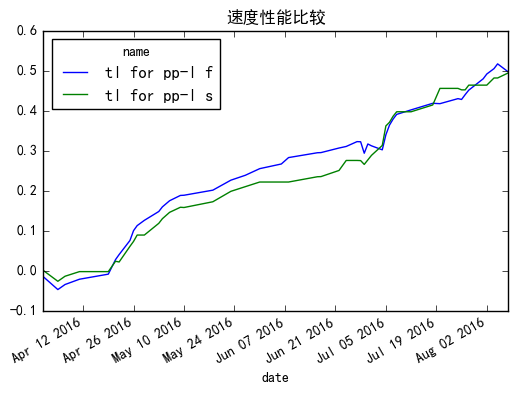

In [15]:
# 从数据库获得每日盈亏，并做图
strategyNames = [strategyNameF, strategyNameS]
strategyBases = [strategyCap,strategyCap]
capFS = plotCapCv(strategyNames,strategyBases,startDate,endDate,title = u'速度性能比较')

### 2.策略参数稳定性分析
    
    通过对参数扫描结果进行聚类分析，来简单评估策略的参数稳定性
    一般来说：
        1.如果聚类分析结果中，策略表现较优的一类数目较多,则策略具有更好的参数稳定性
        2.如果策略表现较优一类的聚类中心仍然有较好的表现，则策略具有更好的参数稳定性

数据集样本
     capital  maxDrawdown          fEMA   wLimit  wLimit1
0  -7.988013    -8.060900 -1.500000e+00 -1.46385     -1.5
1 -10.068257   -10.068257 -1.000000e+00 -1.46385     -1.5
2  -7.189170    -7.200117 -5.000000e-01 -1.46385     -1.5
3  -5.673453    -5.803190  1.110223e-15 -1.46385     -1.5
4  -4.891713    -5.088560  5.000000e-01 -1.46385     -1.5
5  -4.277637    -4.570433  1.000000e+00 -1.46385     -1.5
6  -3.950120    -4.216360  1.500000e+00 -1.46385     -1.5
7  -6.652330    -6.725217 -1.500000e+00 -1.46385     -1.0
8  -8.648767    -9.028597 -1.000000e+00 -1.46385     -1.0
9  -5.913097    -6.431123 -5.000000e-01 -1.46385     -1.0

聚类分析结果
################################################################################
总收益：    0.36 	最大回撤：   -0.12 	集群数目：102
********************************************************************************
fEMA      	wLimit    	wLimit1   	
0.34    	26.03   	28.92   	

################################################################################
总收益：

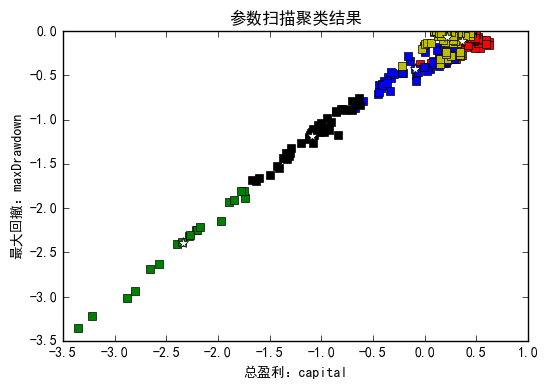

In [16]:
numParam,paramInfo = plotParamInfo(strategyName,n_clust=5)

### 3.策略的品种稳定性
     
     对比不同品种上策略的表现
     如果在不同品种上，策略也能实现盈利，则证明策略本身的稳定性也越好


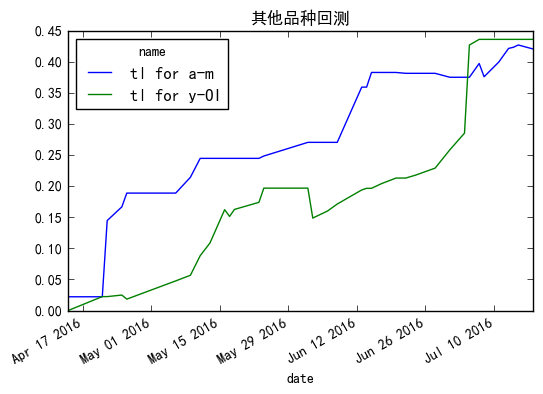

In [17]:
strategyNames = strategyNameL
strategyBases = strategyCapL
capV = plotCapCv(strategyNames,strategyBases,startDate,endDate,title = u'其他品种回测')

### 4.策略的样本外回测
     
     使用相同参数，在样本外回测
     如果在样本外，策略也能实现盈利，则证明策略本身的稳定性也越好

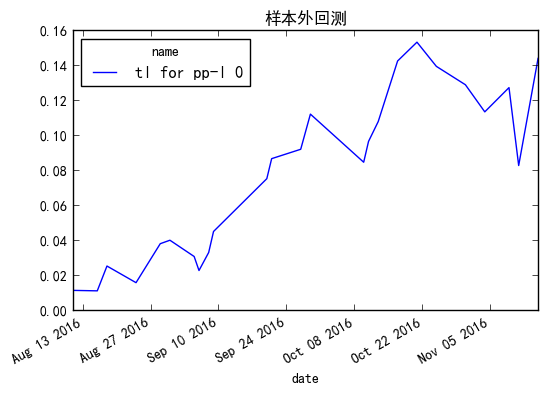

In [18]:
strategyNames = [strategyNameOS]
strategyBases = [strategyCap]
capOS = plotCapCv(strategyNames,strategyBases,startDateOS,endDateOS,title = u'样本外回测')

### 5.性能总结
     
     总结上面所有的分析

In [19]:
print(strategyName+'--策略分析报告')
print('')

# 策略速度性能总结
print(u'1.速度性能')
print('#'*80)
capF = capFS.values[-1][0]
capS = capFS.values[-1][1]
print(u'延时撮合模式下收益为：'+str(capS))
print(u'及时撮合模式下收益为：'+str(capF)) 
print('*'*40)
if capF > capS*1.2:
    print(u'结论 ：策略对交易速度要求高')
else:
    print(u'结论 ：策略对交易速度无要求')
print('')

# 策略品种稳定性总结
print(u'2.品种稳定性')
print('#'*80)
capVT = capV.tail(1)
print(capVT)
nM = np.count_nonzero(capVT<0)
nP = np.count_nonzero(capVT>0)
print('*'*40)
if nP > 0 and nM ==0:
    print(u'结论 ：所有其他品种可以实现盈利')
elif nP > 0:
    print(u'结论 ：部分其他品种可以实现盈利')
else:
    print(u'结论 ：无其他品种可以实现盈利')
print('')

# 策略参数稳定性总结
print(u'3.参数稳定性')
print('#'*80)
aNum = [res[1] for res in paramInfo]
aCap = [res[0][0] for res in paramInfo]
for res in paramInfo:
    print(u'总收益：%8.2f \t最大回撤：%8.2f \t集群数目：%d' %(res[0][0]/numParam, res[0][1]/numParam, res[1]))    
print('*'*40)
if aNum[0] == max(aNum) and aCap[0] > 0:
    print(u'结论 ：策略参数稳定,且能盈利')
elif aNum[0] == max(aNum):
    print(u'结论 ：策略参数稳定,但不能实现盈利')
else:
    print(u'结论 ：策略参数不稳定')
print('')
    
# 策略品种稳定性总结
print(u'4.样本外稳定性')
print('#'*80)
capOS = capOS.tail(1)
print(capOS)
cap = capOS.values[-1][0]
print('*'*40)
if cap>0:
    print(u'结论 ：样本外可以实现盈利')
else:
    print(u'结论 ：样本外不可以实现盈利')
print('')

tl for pp-l--策略分析报告

1.速度性能
################################################################################
延时撮合模式下收益为：0.494309166667
及时撮合模式下收益为：0.496295916667
****************************************
结论 ：策略对交易速度无要求

2.品种稳定性
################################################################################
name        tl for a-m  tl for y-OI
date                               
2016-07-18    0.420387     0.435819
****************************************
结论 ：所有其他品种可以实现盈利

3.参数稳定性
################################################################################
总收益：    0.36 	最大回撤：   -0.12 	集群数目：102
总收益：    0.21 	最大回撤：   -0.07 	集群数目：85
总收益：   -0.10 	最大回撤：   -0.43 	集群数目：47
总收益：   -1.09 	最大回撤：   -1.18 	集群数目：41
总收益：   -2.33 	最大回撤：   -2.39 	集群数目：19
****************************************
结论 ：策略参数稳定,且能盈利

4.样本外稳定性
################################################################################
name        tl for pp-l 0
date                     
2016-11-15        0.14398
*************************

### 6.实盘记录

     使用相同参数，实盘运行的表现

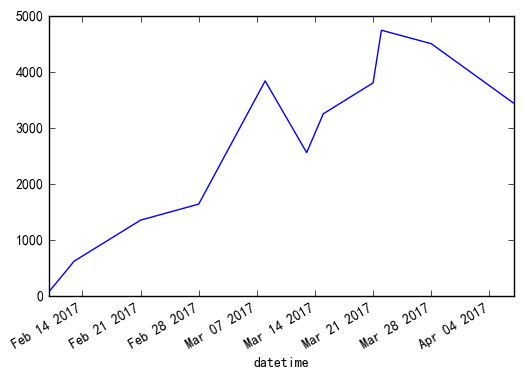

In [20]:
# 实盘记录结果文件名
fileName  = '..\\vn.trader\\ctaAlgo\\actual\\'+strategyName+'.csv'
# 读取并处理数据
pdData = pd.read_csv(fileName)
pdData['cap'] = pdData.apply(np.cumsum)['pnl']
pdData['datetime'] = pdData['date'].map(lambda X:datetime.strptime(str(X), '%Y%m%d'))
pdData = pdData.set_index('datetime')
# 画图
pdData['cap'].plot()
plt.show()

### 7.实盘日志

     1.2月10日启动实盘，策略4手一开
     2.2月13日转为7手一开
     3.2月28日转为3手一开
     4.3月8日至今为8手一开
     5.4月7日发现程序逻辑漏洞，尾盘未能及时平仓，手动平仓造成损失1000元
     6.程序运行期间，因为机房维护造成服务器重启，每次重启需重新初始化，失去多次开仓机会